Viscoelastic Shear in 2D
======

This notebook reproduces figure 1a of Farrington et al (2014).

All material is viscoelastic with equal parameters, differing material indices are prescribed for visualisation purposes. The vertical velocity bc is periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = 1$.  For $t > 1$ the top wall velocity bc is no-slip.

**This example**
1. sets $\eta_\textrm{eff}$ for viscoelastic materials
2. ensures a maximum timestep of $\Delta t_e / 3$
3. modifies stess to include history terms
4. updates stress history term on each particle
5. includes viscoelastic force term 

**References**
Farrington, R. J., L.-N. Moresi, and F. A. Capitanio (2014), The role of viscoelasticity in subducting plates, Geochem. Geophys. Geosyst., 15, 4291–4304, doi:10.1002/2014GC005507.


In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
uw.matplotlib_inline()

import matplotlib.pyplot as pyplot
pyplot.ion()  # this is need so that we don't hang on show() for pure python runs
import numpy as np
import math

import mpi4py
comm = mpi4py.MPI.COMM_WORLD

Create mesh and finite element variables
------

In [2]:
elementType = "Q1/dQ0"
res = 16

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.),
                                 periodic    = [True, False]  ) 

velocityField    = mesh.add_variable(         nodeDofCount=mesh.dim )
pressureField    = mesh.subMesh.add_variable( nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

**Conditions on the boundaries**

In [3]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

shearVelocity = 0.05

for index in mesh.specialSets["MinJ_VertexSet"]:
    velocityField.data[index] = [0., 0.]
for index in mesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index] = [shearVelocity, 0.]
    
periodicBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( jWalls, jWalls) ) 

**Setup a swarm**

In [4]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

**Add swarm variable**

In [5]:
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

materialViscous        = 0
materialViscoelastic   = 1
materialViscoelastic2  = 2

xCoordFn = fn.input()[0]
conditions = [ ( xCoordFn > 0.6 , materialViscoelastic2),
               ( xCoordFn > 0.4 , materialViscoelastic ),
               ( xCoordFn < 0.4 , materialViscoelastic2)]

materialIndex.data[:]  = fn.branching.conditional( conditions ).evaluate(swarm)

# initialise swarm variables for viscoelastic rheology & analysis
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]


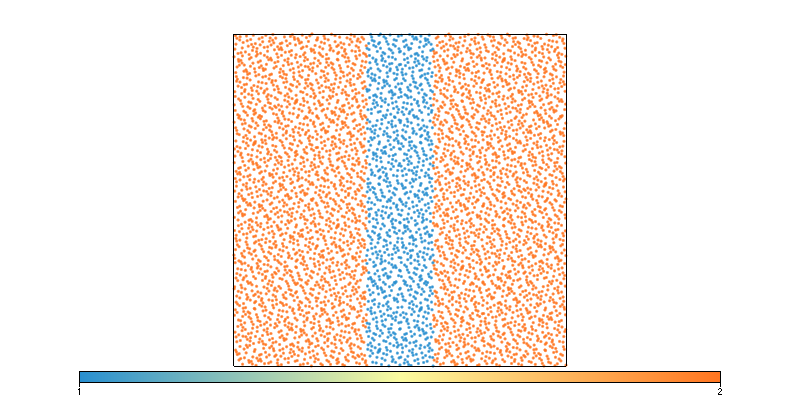

In [6]:
figMaterial = glucifer.Figure( figsize=(800,400) )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=4.0) )
figMaterial.show()

** Define model parameters**

In [7]:
maxT    = 1.0    # max time for shearing velocity BC
eta     = 1.0e2  # viscosity
mu      = 1.0e2  # elastic modulus

alpha   = eta / mu                         # viscoelastic relaxation time
dt_e    = alpha / 10.                      # elastic time step
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

nsteps       = int(10/dt_e*3.)+1     # number of steps to reach t = 10
velBCstep    = int(maxT / (dt_e/3.)) # timestep of maxT

In [8]:
# define viscosity
mappingDictViscosity   = { materialViscous : eta, materialViscoelastic : eta_eff, materialViscoelastic2 : eta_eff }
viscosityMapFn   = fn.branching.map( fn_key=materialIndex, mapping=mappingDictViscosity )

# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

# define stress tensor.
# tauHistoryFn will be passed into Stokes for the ve force term
viscousStressFn        = 2. * viscosityMapFn * strainRate 
tauHistoryFn           = eta_eff / ( mu * dt_e ) * previousStress
viscoelasticeStressFn  = viscousStressFn + tauHistoryFn

mappingDictStress = { materialViscous       : viscousStressFn, 
                      materialViscoelastic  : viscoelasticeStressFn, 
                      materialViscoelastic2 : viscoelasticeStressFn }
stressMapFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictStress )

# density
mappingDictDensity     = { materialViscous : 1.,  materialViscoelastic : 1.,  materialViscoelastic2 : 1. }
densityMapFn     = fn.branching.map( fn_key=materialIndex, mapping=mappingDictDensity )

# buoyancy force term
z_hat   = ( 0.0, 1.0 )
buoyancyFn = -densityMapFn * z_hat

System setup
-----

In [9]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = [periodicBC,],
                               fn_viscosity  = viscosityMapFn, 
                               fn_bodyforce  = buoyancyFn,
                               fn_stresshistory = tauHistoryFn)

solver = uw.systems.Solver( stokes )

In [10]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Main simulation loop
-----

In [11]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    if dt > ( dt_e / 3. ):
        dt = dt_e / 3.  

    # Advect using this timestep size.
    advector.integrate(dt)
    
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressMapFn_data = stressMapFn.evaluate(swarm)
    previousStress.data[:] = ( phi*stressMapFn_data[:] + ( 1.-phi )*previousStress.data[:] )
    
    return time+dt, step+1

In [12]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

tTracer           = np.zeros(nsteps)
previousStress_xy = np.zeros(nsteps)

In [13]:
uw.nProcs()

1

In [14]:
while step < nsteps :
    # solve stokes problem
    solver.solve()
    
    # output for analysis               
    tTracer[step] = time

    # keep record of the zeroth particle's shear stress...
    # note that in parallel, if this particle moves onto another process,
    # you will not get correct results.
    if comm.rank == 0:
        previousStress_xy[step] = previousStress[2].evaluate(swarm)[0]
        
    # We are finished with current timestep, update.
    time, step = update()
    
    # change BC if time > 1.0, then watch stress decay
    if step >= velBCstep:
        for index in mesh.specialSets["MaxJ_VertexSet"]:
            velocityField.data[index] = [0.0, 0.]


Analytic Solution
-----

In [15]:
# analytic soln of elastic shear stress component
V  = shearVelocity
h  = mesh.maxCoord[1] - mesh.minCoord[1]
C1 = -V*V*eta*eta*mu/(mu*mu*h*h + V*V*eta*eta);
C2 = -V*h*eta*mu *mu/(mu*mu*h*h + V*V*eta*eta);

increment =  1000 #int(10 / (dt_e / 3.0) )
t = np.linspace(0, 10, increment)
analyticSoln = np.zeros(increment)

for i in range(1,int(increment)):
    if t[i] <= maxT:
        analyticSoln[i] = np.exp(-mu/eta*t[i])*(C2*np.cos(V*t[i]/h)-C1*np.sin(V*t[i]/h))-C2
    if t[i] > maxT:
        analyticSoln[i] =(np.exp(-mu/eta*maxT)*(C2*np.cos(V*maxT/h)-C1*np.sin(V*maxT/h))-C2)*np.exp(-mu/eta*(t[i]-maxT))

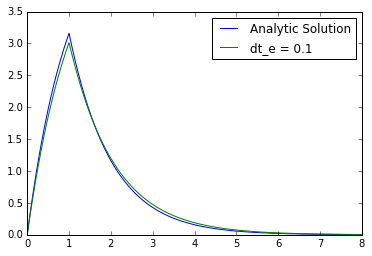

In [16]:
# plot elastic stress portion of total stress & analytic solution
if comm.rank == 0:
    fig, (plot) = pyplot.subplots(1,1)

    plot.plot(t, analyticSoln, label='Analytic Solution')
    plot.plot(tTracer, previousStress_xy, label='dt_e = '+str(dt_e))
    plot.legend(loc='upper right')
    plot.axis([0, 8, 0, 3.5])

    pyplot.show()


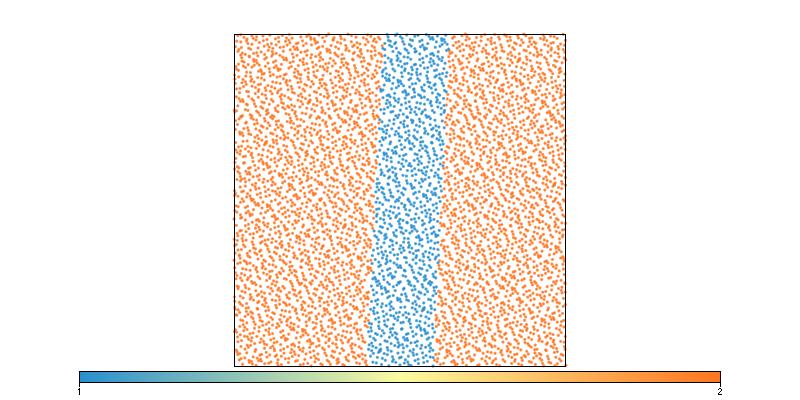

In [17]:
figMaterial.show()